In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import six
import tensorflow as tf

from edward.models import (
    Categorical, Dirichlet, Empirical, InverseGamma,
    MultivariateNormalDiag, Normal, ParamMixture, Bernoulli)

plt.style.use('ggplot')

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
class dataset(object):
    def __init__(self, N, M, D1, D2):
        self.N = N
        self.M = M
        self.D1 = D1
        self.D2 = D2
        self.Z = np.zeros((N,D1), dtype=np.float32)
        self.X = np.zeros((N,D2), dtype=np.float32)
        self.Y = np.zeros((N,1))
        self.C = np.zeros((N,1), dtype=np.float32)
        self.beta = None
        self.mus = None
        self.stds = None
        self.WX = None
        self.WY = None
        self.sigmaX = None
        
    def create(self):
        beta = np.random.dirichlet([1]*self.M)
        mus = np.random.randn(self.M, self.D1)*2
        stds = [[1, 1]]*self.M
        WX = np.random.randn(self.D1, self.D2)
        WY = np.random.randn(self.D1)
        sigmaX = [1,1,1]
        
        for n in range(self.N):
            c = np.argmax(np.random.multinomial(1, beta))
            self.C[n,:] = c
            self.Z[n, :] = np.random.multivariate_normal(mus[c], np.diag(stds[c]))
            self.X[n, :] = np.random.multivariate_normal(np.matmul(self.Z[n],WX), np.diag(sigmaX))
            self.Y[n,:] = np.random.binomial(1,1/(1+np.exp(-np.matmul(self.Z[n],WY))))

        
        self.beta = beta
        self.mus = mus
        self.stds = stds
        self.WX = WX
        self.WY = WY
        self.sigmaX = sigmaX

    def print_params(self):
        print("Cluster Probabilities:", self.beta)
        print("Centers:")
        for i in range(self.M):
            print(self.mus[i,:])
            
        
    def visualize(self):
        color = ['r','g','b','y','c','n','k']
        marker = ['x','+','0']
        for i in [0,1]:
            classpoints = np.where(self.Y==i)
            for j in range(self.M):
                points = np.where(self.C[classpoints]==j)
                Z = self.Z[classpoints[0],:]
                plt.plot(Z[points, 0], Z[points, 1], color[j]+marker[i])
#                 plt.axis([-20,20,-20,20])
                plt.title("Simulated dataset")
        plt.show()
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for i in [0,1]:
            classpoints = np.where(self.Y==i)
            for j in range(self.M):
                points = np.where(self.C[classpoints]==j)
                X = self.X[classpoints[0],:]
                plt.scatter(X[points, 0], X[points, 1], X[points,2],c=color[j], marker=marker[i])
        plt.show()
        

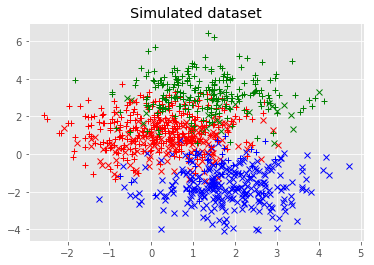

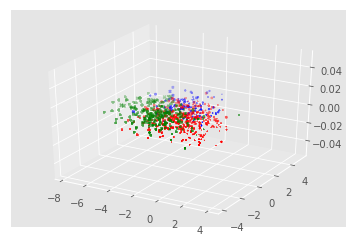

In [5]:
N = 1000
M = 3
D1 = 2
D2 = 3
data = dataset(N, M, D1, D2)
data.create()
data.visualize()

In [6]:
beta = Dirichlet(tf.ones(M))
mu = Normal(tf.zeros(D1), tf.ones(D1), sample_shape=M)
sigmasq = InverseGamma(tf.ones(D1), tf.ones(D1), sample_shape=M)
z = ParamMixture(beta, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)},
                 MultivariateNormalDiag,
                 sample_shape=N)
c = z.cat
wx = Normal(loc=tf.zeros([D2, D1]), scale=tf.ones([D2, D1]))
wy = Normal(loc=tf.zeros([1, D1]), scale=tf.ones([1, D1]))
x = Normal(loc=tf.matmul(z, wx, transpose_b=True), scale=tf.ones([N, D2]))
y = Bernoulli(logits=tf.matmul(z, wy, transpose_b=True))

In [13]:
qz = Normal(loc=tf.Variable(tf.random_normal([N, D1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([N, D1]))))
qmu = Normal(loc=tf.Variable(tf.random_normal([M, D1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([M, D1]))))
qwx = Normal(loc=tf.Variable(tf.random_normal([D2, D1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([D2, D1]))))
qwy = Normal(loc=tf.Variable(tf.random_normal([1, D1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1, D1]))))
qc = Categorical(logits=tf.Variable(tf.zeros([N,M])))

inference = ed.KLqp({mu: qmu, c: qc}, data={x: data.X, y: data.Y})
#  , z: qz, wy: qwy, wx: qwx
inference.run(n_iter=500, n_print=100, n_samples=50)

500/500 [100%] ██████████████████████████████ Elapsed: 82s | Loss: 62121.449


In [ ]:
# T = 500  # number of MCMC samples
# qbeta = Empirical(tf.Variable(tf.ones([T, M]) / M))
# qmu = Empirical(tf.Variable(tf.zeros([T, M, D1])))
# qsigmasq = Empirical(tf.Variable(tf.ones([T, M, D1])))
# qc = Empirical(tf.Variable(tf.zeros([T, N], dtype=tf.int32)))
# inference = ed.Gibbs({beta: qbeta, mu: qmu, sigmasq: qsigmasq, c: qc},
#                      data={x: data.X})
# inference.initialize()


# sess = ed.get_session()
# tf.global_variables_initializer().run()

# t_ph = tf.placeholder(tf.int32, [])
# running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)

# for _ in range(inference.n_iter):
#   info_dict = inference.update()
#   inference.print_progress(info_dict)
#   t = info_dict['t']
#   if t % inference.n_print == 0:
#     print("\nInferred cluster means:")
#     print(sess.run(running_cluster_means, {t_ph: t - 1}))

In [14]:
sess = ed.get_session()
print("Inferred prototypes axes:")
data.print_params()
print("________________________\n")

pred_mean2 = qmu.mean()
print(sess.run(qmu.mean()))
print(np.sum(np.argmax(sess.run(qc.probs), axis=1)==data.C[:,0]))

Inferred prototypes axes:
Cluster Probabilities: [ 0.43807227  0.27519704  0.28673069]
Centers:
[ 0.2766416   1.15936889]
[ 1.2798353  3.1147945]
[ 1.8535601  -1.56818906]
________________________

[[-1.67048693 -4.42258406]
 [-0.49124414  3.42858553]
 [ 1.62736893  2.6204927 ]]
332


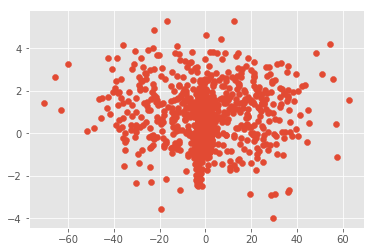

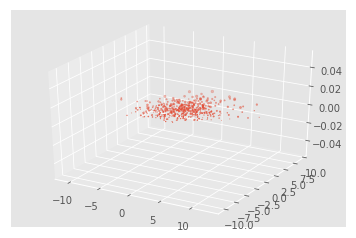

-8.72354


In [15]:
z_post = ed.copy(z, {c: qc, mu: qmu})
z_gen = sess.run(z_post)
plt.scatter(z_gen[:,0], z_gen[:, 1])
plt.show()

x_post = ed.copy(x, {wx: qwx, z: qz, c: qc, wy: qwy, mu: qmu})
x_gen = sess.run(x_post)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.scatter(x_gen[:,0], x_gen[:, 1], x_gen[:,2])
plt.show()

print(ed.evaluate('log_likelihood', data={x_post: data.X}))